# (16.0) Описание решаемой задачи

В окружении выявленного айсберга необходимо осуществить поиск заявок, которые потенциально могут быть элементами цепочки всплытия айсберга, но при исполнении не были выявлены как айсберг, так как сделка была произведена ровно на объем видимой части. Для полученных результатов осуществить перебор дельт и выбрать наиболее оптимальную для дальнейшего использования

# (16.1) Установка всех необходимых пакетов¶

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (16.2) Определение функций¶

In [6]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки перед айсбергом
def ChainPairPrev(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        prev_orderno = list_of_orderno[i+1]
        cur_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        cur_time_place = orders_instr.loc[cur_time_place_1,'TIME']
        prev_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == prev_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        prev_time_trd = orders_instr.loc[prev_time_trd_1,'TIME']
    
        if (cur_time_place >= prev_time_trd) and ((cur_time_place - prev_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, prev_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки после айсберга
def ChainPairSuc(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        suc_orderno = list_of_orderno[i+1]
        cur_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        cur_time_trd = orders_instr.loc[cur_time_trd_1,'TIME']
        suc_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == suc_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        suc_time_place = orders_instr.loc[suc_time_place_1,'TIME']
    
        if (suc_time_place >= cur_time_trd) and ((suc_time_place - cur_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, suc_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# (16.3) Список всех используемых датафреймов

In [7]:
# orders - ордерлог на заданную дату
# iceberg_all - список всех найденных айсбергов
# orders_instr - ордерлог по инструменту
# ice_instr - список айсбергов по одному инструменту за один день

# (16.4) Определение входных параметров

In [8]:
# создаем список из всех названий файлов с данными (из них в дальнейшем можно извлечь дату)
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [9]:
# создаем список из инструментов
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [50]:
d = orderlogs[0] 
date = int(d[8:16]) #20190304
ticker = 'MGNT'
delta = dt.timedelta(microseconds=99000)

# (16.5) Чтение данных

In [11]:
%%time
# преобразуем time в формат datetime
# orders - ордерлог за день
# instr_orders - ордерлог на заданную дату по выбранному инструменту на момет времени t
orders = pd.read_csv(d, header = 0)
orders['together_time'] = str(date)+orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']

CPU times: user 5min 24s, sys: 3.24 s, total: 5min 27s
Wall time: 5min 30s


In [37]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1120,1121,SNGS,B,2019-03-04 10:00:00.000000,1121,1,25.300,11100,NaN,NaN
1,1765,1766,SNGS,S,2019-03-04 10:00:00.000000,1766,1,26.985,100,NaN,NaN
2,1773,1774,SNGS,S,2019-03-04 10:00:00.000000,1774,1,26.930,100,NaN,NaN
3,1821,1822,SNGS,B,2019-03-04 10:00:00.000000,1822,1,24.000,4000,NaN,NaN
4,2027,2028,SNGS,B,2019-03-04 10:00:00.000000,2028,1,25.050,500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
101834,5423971,5423972,SNGS,B,2019-03-04 18:43:02.914362,2497267,0,25.000,100,NaN,NaN
101835,5424115,5424116,SNGS,B,2019-03-04 18:43:57.825126,2483698,0,25.410,200,NaN,NaN
101836,5424138,5424139,SNGS,B,2019-03-04 18:44:06.557831,1964577,0,25.120,100,NaN,NaN
101837,5424182,5424183,SNGS,B,2019-03-04 18:44:18.375166,172842,0,25.330,10000,NaN,NaN


In [19]:
# читаем список выявленных айсберг-заявок + преобразуем время в формат datetime
# iceberg_all - список всех найденных айсбергов
# ice_instr - список айсбергов по одному инструменту за один день
iceberg_all = pd.read_csv('iceberg.csv', header = 0)
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']

In [38]:
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]
ice_instr

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1625,0,S,20190304,1,339012,25.600,SNGS,2019-03-04 10:26:54.472503,2019-03-04 10:28:34.837618,-3000,10000,00:01:40.365115
1626,1,S,20190304,1,350247,25.600,SNGS,2019-03-04 10:28:34.850526,2019-03-04 10:28:36.839055,-3000,7000,00:00:01.988529
1627,2,S,20190304,1,350458,25.600,SNGS,2019-03-04 10:28:36.851957,2019-03-04 10:28:57.929089,-3100,7000,00:00:21.077132
1628,3,S,20190304,1,352336,25.600,SNGS,2019-03-04 10:28:57.970874,2019-03-04 10:29:28.107744,-200,6900,00:00:30.136870
1629,4,S,20190304,1,355414,25.600,SNGS,2019-03-04 10:29:37.209951,2019-03-04 10:30:03.654620,-100,10000,00:00:26.444669
1630,5,S,20190304,1,403864,25.600,SNGS,2019-03-04 10:38:05.378403,2019-03-04 10:38:08.548370,-700,10000,00:00:03.169967
1631,6,S,20190304,1,404838,25.600,SNGS,2019-03-04 10:38:08.551354,2019-03-04 10:39:53.932688,-100,9300,00:01:45.381334
1632,7,S,20190304,1,436852,25.600,SNGS,2019-03-04 10:43:22.408340,2019-03-04 10:43:22.408340,-16000,11000,00:00:00
1633,8,B,20190304,1,443845,25.605,SNGS,2019-03-04 10:44:54.271848,2019-03-04 11:06:00.261313,-5700,10000,00:21:05.989465
1634,9,B,20190304,1,788464,25.640,SNGS,2019-03-04 11:40:31.533008,2019-03-04 11:40:31.533008,-6400,10000,00:00:00


In [39]:
ice_instr[ice_instr['ORDERNO']== 2300971]

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1644,19,B,20190304,1,2300971,25.5,SNGS,2019-03-04 17:50:21.907739,2019-03-04 17:50:54.880657,-5700,50000,00:00:32.972918


# (16.6) Выбираем айсберг для анализа

In [40]:
# вводим индекс айсберга из списка его окружения и извлекаем основную информацию из него
id = 1644
test = ice_instr.loc[id]
buysell = ice_instr.loc[id][1]
date = ice_instr.loc[id][2]
orderno = ice_instr.loc[id][4]
price = ice_instr.loc[id][5]
ticker = ice_instr.loc[id][6]
time_place = ice_instr.loc[id][7]
time_ident = ice_instr.loc[id][8]
volume_ini = ice_instr.loc[id][10]

test

index                                 19
BUYSELL                                B
DATE                            20190304
ICEBERG                                1
ORDERNO                          2300971
PRICE                               25.5
SECCODE                             SNGS
TIME          2019-03-04 17:50:21.907739
TIME_IDENT    2019-03-04 17:50:54.880657
VOLUME                             -5700
VOLUME_INI                         50000
DELTA             0 days 00:00:32.972918
Name: 1644, dtype: object

# (16.7) Анализ интервала перед выставлением айсберга для поиска потенциальных элементов микроцепочки

Предполагается, что найденный айсберг - это элемент цепочки всплытия айсберга и перед ним была исполнена как минимум одна заявка на объем видимой части, которая и инициировала всплытие айсберга. Поиск таких заявок необходимо осуществлять поиск заявок, удовлетворяющих следующим условиям:
1. orders_instr.ORDERNO < orderno  
2. orders_instr.PRICE == price
3. orders_instr.BUYSELL == buysell
4. время выставления следующей заявки находится в допустимом интервале после исполнения предыдущей
5. объем выставленной заявки == объему исполнения (НО! надо найти заявку с ACTION = 1 для этого)

In [334]:
%%time

ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
cur_price = orders_instr.loc[ice_index,'PRICE']

'''for i in range(ice_index):
        
        cur_index = ice_index - i
        for_lob = orders_instr[orders_instr.index <= cur_index]

        if buysell == 'B':
            
            if GlassBuild(for_lob)[0] < cur_price:

                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                
                break

        elif buysell == 'S':
            
            if GlassBuild(for_lob)[4] > cur_price:
                
                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                 
                break
print(left_border)'''

'''if left_border >= (time_place - delta):
    
    left_border = (time_place - delta)'''

left_border = ReverseToDateTime('20190304100000000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
test = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= left_border)& 
             (orders_instr.TIME <= time_ident)&
             (orders_instr.ORDERNO < orderno)&
             (orders_instr.ACTION == 2)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
# test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
test1 = []

for i in test:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    
    if order_volume == volume_ini:
        
        test1.append(i)

# дописываем номер айсберг заявки в найденную цепочку
test1.append(orderno)
# разворачиваем список заявок от самой новой до самой старой
test1 = test1[::-1]

# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_prev = ChainPairPrev(test1)
chain_prev

CPU times: user 114 ms, sys: 28.1 ms, total: 142 ms
Wall time: 157 ms


[1118463, 1118452, 1118245, 1118242, 1118237]

In [45]:
orders_instr[orders_instr['ORDERNO'].isin (chain_prev)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


# (16.5) Анализ интервала после вскрытия айсберга для поиска потенциальных элементов микроцепочки



In [335]:
%%time
right_border = ReverseToDateTime('20190304184500000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
train = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= time_ident)& 
             (orders_instr.TIME <= right_border)&
             (orders_instr.ORDERNO > orderno)&
             (orders_instr.ACTION == 1)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
# train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
train1 = [orderno]

for i in train:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()
    
    if (order_volume == volume_ini) and (order_volume <= trade_volume):
        
        train1.append(i)
        
# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_suc = ChainPairSuc(train1)
chain_suc

CPU times: user 1.04 s, sys: 18.7 ms, total: 1.05 s
Wall time: 1.09 s


[1118463]

In [115]:
orders_instr[orders_instr['ORDERNO'].isin (chain_suc)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315288,4953515,4953516,GAZP,B,2019-03-04 18:02:41.726467,2391577,1,155.0,1000,NaN,NaN
315295,4953583,4953584,GAZP,B,2019-03-04 18:02:41.754006,2391577,2,155.0,590,2.936006e+09,155.0
315298,4953598,4953599,GAZP,B,2019-03-04 18:02:41.756361,2391577,2,155.0,1600,2.936006e+09,155.0


# (16.6) Объединяем цепочки

Объединяем цепочку до с цепочкой после. Заносим информацию по цепочке (ордерно первого элемента chain) в ice_instr.chain_id  всех найденных айсбергов 
Добавить в цикл условие, что анализ цепочек проводится только для тех айсбергов, у которых пустой ice_instr.chain_id

In [336]:
# объединяем цепочку до с цепочкой после
chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
chain

[1118237, 1118242, 1118245, 1118452, 1118463]

In [117]:
orders_instr[orders_instr['ORDERNO'].isin (chain)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


In [118]:
# определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id
ices = ice_instr.index[ice_instr['ORDERNO'].isin(chain)].to_list()

for i in ices:
    
    ice_instr.loc[i, 'CHAIN_ID'] = chain[0]

In [332]:
t = [1118237, 1118242, 1118245, 1118452, 1118463]
ice_instr[ice_instr['ORDERNO'].isin (t)]

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1778,36,S,20190304,1,1118463,94.11,ALRS,2019-03-04 12:48:45.006040,2019-03-04 12:48:45.045541,-1370,1500,00:00:00.039501


# (16.7) Создаем цикл, в котором для разных дельт будет считаться длина цепочек одного и того же айсберга

In [265]:
d = orderlogs[0] 
date = int(d[8:16]) #20190304
ticker = tickers[11] #SBER
delta = dt.timedelta(microseconds=99000)

In [53]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]

In [268]:
ice_instr

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1571,0,S,20190304,1,210565,0.036095,VTBR,2019-03-04 10:07:44.042531,2019-03-04 10:07:44.492423,-2000000,1000000,00:00:00.449892
1572,1,S,20190304,1,562290,0.036090,VTBR,2019-03-04 11:06:25.856876,2019-03-04 11:07:56.489665,-6500000,1000000,00:01:30.632789
1573,2,S,20190304,1,983334,0.036120,VTBR,2019-03-04 12:22:03.901721,2019-03-04 12:22:03.901721,-410000,1000000,00:00:00
1574,3,S,20190304,1,983338,0.036120,VTBR,2019-03-04 12:22:03.904343,2019-03-04 12:22:04.062148,-790000,590000,00:00:00.157805
1575,4,S,20190304,1,983356,0.036120,VTBR,2019-03-04 12:22:04.219866,2019-03-04 12:23:05.287500,-1250000,210000,00:01:01.067634
1576,5,S,20190304,1,987072,0.036120,VTBR,2019-03-04 12:23:05.288663,2019-03-04 12:24:20.205902,-970000,750000,00:01:14.917239
1577,6,S,20190304,1,991669,0.036120,VTBR,2019-03-04 12:24:20.216957,2019-03-04 12:25:20.211152,-240000,30000,00:00:59.994195
1578,7,S,20190304,1,1004697,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-2550000,1000000,00:00:00
1579,8,S,20190304,1,1004698,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-30000,450000,00:00:00
1580,9,S,20190304,1,1004699,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-2540000,970000,00:00:00


In [267]:
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,326,327,VTBR,S,2019-03-04 10:00:00.000000,327,1,0.039045,10000,NaN,NaN
1,346,347,VTBR,B,2019-03-04 10:00:00.000000,347,1,0.032850,10000,NaN,NaN
2,363,364,VTBR,S,2019-03-04 10:00:00.000000,364,1,0.036300,10000,NaN,NaN
3,523,524,VTBR,B,2019-03-04 10:00:00.000000,524,1,0.034265,100000,NaN,NaN
4,852,853,VTBR,B,2019-03-04 10:00:00.000000,853,1,0.035100,160000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
130260,5424021,5424022,VTBR,S,2019-03-04 18:43:25.066411,2583125,0,0.036030,10000000,NaN,NaN
130261,5424077,5424078,VTBR,B,2019-03-04 18:43:41.898698,2458385,0,0.035870,2000000,NaN,NaN
130262,5424142,5424143,VTBR,B,2019-03-04 18:44:07.621960,2346176,0,0.035195,20000000,NaN,NaN
130263,5424169,5424170,VTBR,S,2019-03-04 18:44:13.393783,2227849,0,0.036110,2850000,NaN,NaN


In [54]:
# выбираем айсберг для анализа
id = 1455
test = ice_instr.loc[id]
buysell = ice_instr.loc[id][1]
date = ice_instr.loc[id][2]
orderno = ice_instr.loc[id][4]
price = ice_instr.loc[id][5]
ticker = ice_instr.loc[id][6]
time_place = ice_instr.loc[id][7]
time_ident = ice_instr.loc[id][8]
volume_ini = ice_instr.loc[id][10]

test

index                                 29
BUYSELL                                S
DATE                            20190304
ICEBERG                                1
ORDERNO                          1279777
PRICE                               3895
SECCODE                             MGNT
TIME          2019-03-04 13:20:20.116766
TIME_IDENT    2019-03-04 13:20:20.117273
VOLUME                               -20
VOLUME_INI                           143
DELTA             0 days 00:00:00.000507
Name: 1455, dtype: object

In [55]:
sum = 10000
delta_list = [sum]

while sum <= 999000:
    
    sum = sum + 10000
    delta_list.append(sum)

In [56]:
%%time
results = []

for j in delta_list:
    
    delta = dt.timedelta(microseconds=j)
    ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
    cur_price = orders_instr.loc[ice_index,'PRICE']


    left_border = ReverseToDateTime('20190304100000000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= left_border)& 
                 (orders_instr.TIME <= time_ident)&
                 (orders_instr.ORDERNO < orderno)&
                 (orders_instr.ACTION == 2)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
    # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    test1 = []

    for i in test:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

        if order_volume == volume_ini:

            test1.append(i)

    # дописываем номер айсберг заявки в найденную цепочку
    test1.append(orderno)
    # разворачиваем список заявок от самой новой до самой старой
    test1 = test1[::-1]

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_prev = ChainPairPrev(test1)

    right_border = ReverseToDateTime('20190304184500000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    train = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= time_ident)& 
                 (orders_instr.TIME <= right_border)&
                 (orders_instr.ORDERNO > orderno)&
                 (orders_instr.ACTION == 1)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
    # train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    train1 = [orderno]

    for i in train:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
        trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()

        if (order_volume == volume_ini) and (order_volume <= trade_volume):

            train1.append(i)

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_suc = ChainPairSuc(train1)
    chain_suc

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_suc = ChainPairSuc(train1)
    
    chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
    
    results.append([j, len(chain)])

CPU times: user 3min 10s, sys: 4.17 s, total: 3min 14s
Wall time: 3min 27s


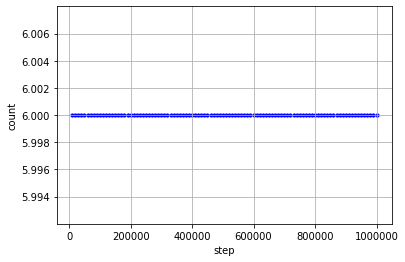

In [57]:
step = []
count = []

for i in range(len(results)):
    
    step.append(results[i][0])
    count.append(results[i][1])
    
df1 = pd.DataFrame({'step':pd.Series(step),
     'count': pd.Series(count)})

df1.plot.scatter(x='step', y='count', s=10, color='blue', grid=True)